<a href="https://colab.research.google.com/github/sovb/Garbage-Classification/blob/main/Garbage_Classification-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will begin by enabling autoreload so that we can "reimport" a module without having to restart Python completely. This is becasue when we run the first time the module will be in the sys.modlue dictionary and the interpreter will not import it again if it is already present there.
As for matplotlib inline, with this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
#added by sovra
import scipy
from scipy import *
import skimage
from skimage import filters
from skimage import io 
import matplotlib.pyplot as plt  #added by sovra
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

**Extract Data from TrashNet dataset zip file**
https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip

In [3]:
files = zf.ZipFile("/content/drive/MyDrive/Colab Notebooks/dataset-resized.zip",'r')

files.extractall()
files.close()

In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'metal', 'plastic', 'cardboard', 'paper', 'trash', 'glass']

**Organize images into different folders**
1.   Cardboard
2.   Glass
3.   Paper
4.   Metal
5.   Plastic
6.   Trash

Train, validation and test ratio being used here will be 50-25-25 however, we can modify this to 70-15-15 later on and see if there is a difference. 

In [5]:
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [6]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
          
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
      
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [7]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [8]:
tfms = vision.get_transforms(do_flip=True,flip_vert=True)
data = vision.ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16,size=256) #default size for bs is 64

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [9]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/data

In [10]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
learn = vision.cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

https://concordiauniversity.on.worldcat.org/search?queryString=Recyclable%20waste%20image%20recognition%20based%20on%20deep%20learning&databaseList= 

We are pre-processing the image here to convert the input RGB image into a single-channel gray image,
and perform Gaussian blur on the gray image., randomly crop the image, rotate it, then finally crop the image into a 256x256 pixel RGB image and normalize.

Major resource: 
https://www.section.io/engineering-education/image-preprocessing-in-python/ 

What I will do now, is make an array of labels 
I also need some type of X_train array?
to make y labels we can loop through and read in filename as a string and search for eg. cardboard and if true then that label is 1(for cardboard)

Now that we have preprocessed, 
**LET'S START TRAINING!!!**

https://www.youtube.com/watch?v=qMFKsMeE6fM

at 6:30 they talk about lr_schedule which refers to this in our guide document "reduced by 10 times every 90 cycles,"

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


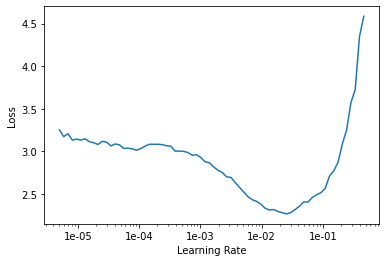

In [13]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

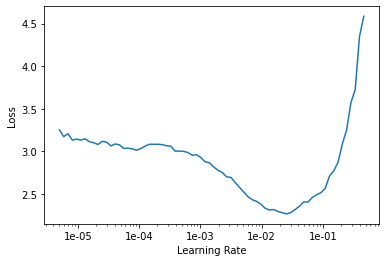

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.553537,1.009305,0.282540,08:52
1,1.028320,0.539017,0.177778,08:53


In [16]:
interp = vision.ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

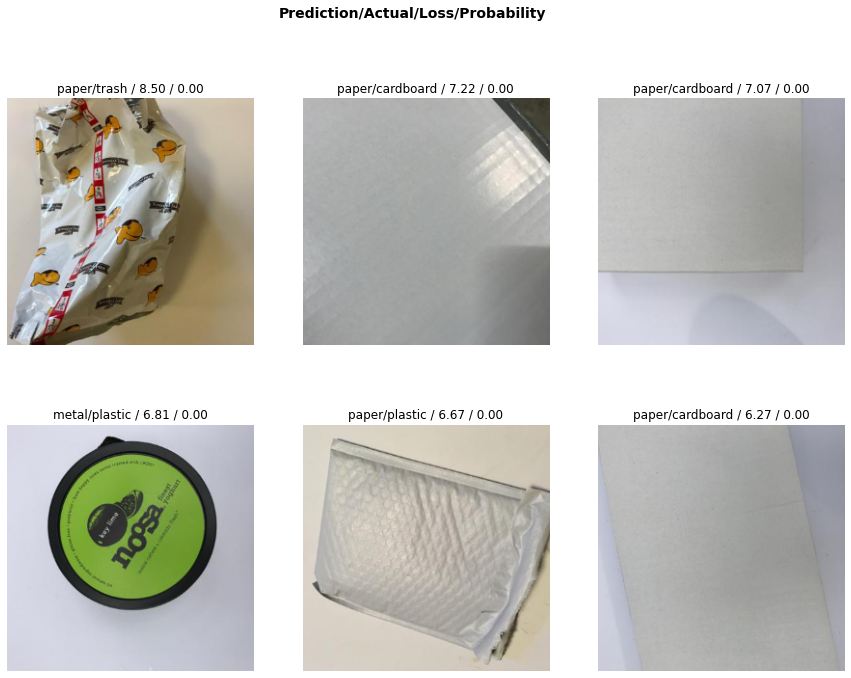

In [17]:
interp.plot_top_losses(6, figsize=(15,11))

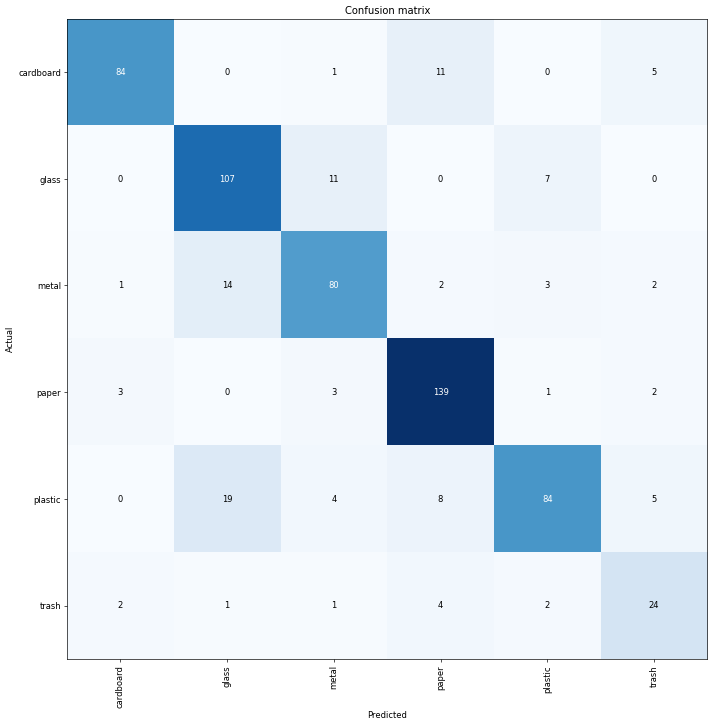

In [18]:
vision.doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('plastic', 'glass', 19),
 ('metal', 'glass', 14),
 ('cardboard', 'paper', 11),
 ('glass', 'metal', 11),
 ('plastic', 'paper', 8),
 ('glass', 'plastic', 7),
 ('cardboard', 'trash', 5),
 ('plastic', 'trash', 5),
 ('plastic', 'metal', 4),
 ('trash', 'paper', 4),
 ('metal', 'plastic', 3),
 ('paper', 'cardboard', 3),
 ('paper', 'metal', 3),
 ('metal', 'paper', 2),
 ('metal', 'trash', 2),
 ('paper', 'trash', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'plastic', 2)]

In [20]:
preds = learn.get_preds(ds_type=vision.DatasetType.Test)

In [21]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [22]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [23]:
result = []
for max_idx in max_idxs:
    result.append(data.classes[max_idx])

In [24]:
result

['cardboard',
 'metal',
 'cardboard',
 'plastic',
 'trash',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'cardboard',
 'glass',
 'trash',
 'cardboard',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'metal',
 'metal',
 'glass',
 'plastic',
 'cardboard',
 'paper',
 'cardboard',
 'trash',
 'paper',
 'paper',
 'plastic',
 'paper',
 'glass',
 'paper',
 'paper',
 'trash',
 'cardboard',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'glass',
 'glass',
 'metal',
 'paper',
 'cardboard',
 'plastic',
 'plastic',
 'metal',
 'plastic',
 'metal',
 'plastic',
 'cardboard',
 'paper',
 'plastic',
 'glass',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'trash',
 'plastic',
 'metal',
 'paper',
 'cardboard',
 'glass',
 'glass',
 'plastic',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'paper',
 'paper',
 'glass',
 'plastic',
 'metal',
 'metal',
 'paper',
 'paper',
 'glass',
 'metal',
 'glass',
 'ca

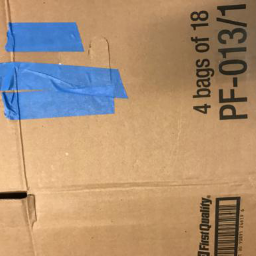

In [25]:
learn.data.test_ds[0][0]

In [26]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [27]:
## predicted values
print(result[0:5])
## actual values
print(y[0:5])

['cardboard', 'metal', 'cardboard', 'plastic', 'trash']
['cardboard', 'plastic', 'cardboard', 'plastic', 'trash']


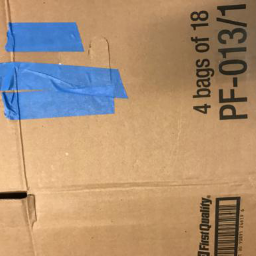

In [28]:
learn.data.test_ds[0][0]

In [29]:
cm = confusion_matrix(y,result)
print(cm)

[[ 86   0   6   6   1   2]
 [  0  97  16   1  12   0]
 [  1  18  76   4   4   0]
 [  1   0   2 143   0   3]
 [  1  22   3   6  87   2]
 [  1   3   4   2   2  23]]


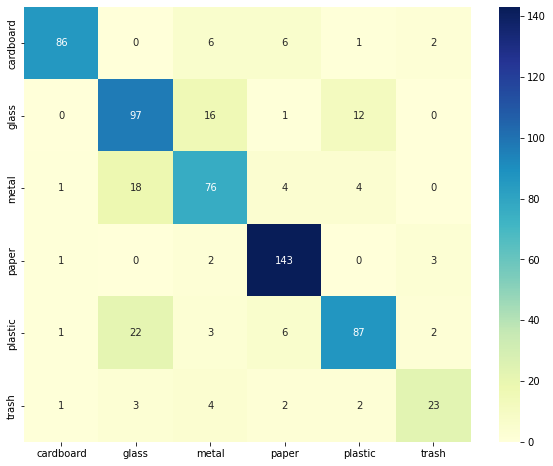

In [30]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [31]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [32]:
accuracy = correct/sum(sum(cm))
accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  """Entry point for launching an IPython kernel.


0.8062992125984252